In [50]:
import librosa
import librosa.feature
import librosa.display

import matplotlib.pyplot as plt

import numpy as np
from scipy import signal
import scipy.stats
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import sklearn.metrics
import sklearn
from scipy.spatial.distance import  mahalanobis
import cv2

from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

import torch
import torchaudio

import seaborn as sns

import pandas as pd
import os
import re

from FSDDComparisonHelp import FSDD, getMFCC, getTwoMFCCs, showMFCC, compareFeatures

from sklearn import preprocessing
import python_speech_features as mfcc

# plt.style.use("classic")
# plt.style.use("bmh")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.grid'] = True

In [43]:
def getTrainSet(speakerFilesList : list):
    trainList = []
    for file in speakerFilesList:
        y, sr = librosa.load(file)
        # S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=80, fmax=8000)
        S = librosa.feature.mfcc(y=y, sr=sr, dct_type=1)
        trainList.append(S)
    # trim
    minLen = min(el.shape[1] for el in trainList)
    trainList = [el[:, :minLen] for el in trainList]
    # stack
    train = np.stack(trainList)
    # reshape to 2d
    nSamples, nx, ny = train.shape
    twoDimTrain = train.reshape((nSamples, nx*ny))
    print(f'nx = {nx}, ny = {ny}')
    return twoDimTrain, nx, ny


def getTestSet(speakerFilesList : list, maxLen : int):
    trainList = []
    for file in speakerFilesList:
        y, sr = librosa.load(file)
        # S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=80, fmax=8000)
        S = librosa.feature.mfcc(y=y, sr=sr, dct_type=1)
        trainList.append(S)
    # trim
    minLen = min(el.shape[1] for el in trainList)
    trainList = [el[:, :min(maxLen, minLen)] for el in trainList]
    # shapes = {arr.shape for arr in trainList}
    # print(shapes)
    # stack
    train = np.stack(trainList)
    # reshape to 2d
    nSamples, nx, ny = train.shape
    twoDimTrain = train.reshape((nSamples, nx*ny))
    print(f'nx = {nx}, ny = {ny}')
    return twoDimTrain

def extractMFCCs(y, sr):
    return librosa.feature.mfcc(
            y=y,
            sr=sr,
            n_mfcc=12,
            dct_type=3,
            n_fft=512,
            hop_length=256
        )


def getFeatureList(speakerFilesList : list):
    featureList = []
    for file in speakerFilesList:
        y, sr = librosa.load(file)
        # S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=80, fmax=8000)
        S = extractMFCCs(y, sr)
        # S = librosa.feature.mfcc(y=y, sr=sr, dct_type=3)
        featureList.append(S)
    return featureList

def getNormalisedMFCCsList(speakerFilesList : list):
    featureList = []
    for file in speakerFilesList:
        y, sr = librosa.load(file)
        S = extractMFCCs(y, sr)
        S = sklearn.preprocessing.scale(S, axis=1)
        featureList.append(S)
    return featureList

def getDeltasList(speakerFilesList : list):
    featureList = []
    for file in speakerFilesList:
        y, sr = librosa.load(file)
        S = extractMFCCs(y, sr)
        S = sklearn.preprocessing.scale(S, axis=1)
        S = librosa.feature.delta(S, width=3)
        featureList.append(S)
    return featureList

def trimFeatures(collection : list):
    newCollection = []
    minLen = min(min([feature.shape[1] for feature in featureList]) for featureList in collection)
    for featureList in collection:
        newFeatureList = [feature[:, :minLen] for feature in featureList]
        newCollection.append(newFeatureList)
    return newCollection

def getLinearFeatureList(featureList : list):
    res = np.stack(featureList)
    # reshape to 2d
    nSamples, nx, ny = res.shape
    twoDimRes = res.reshape((nSamples, nx*ny))
    return twoDimRes, nx, ny

# def trim(collection):
# 	minLen = min(el.shape[1] for el in collection)
# 	collection = [el[:, :minLen] for el in collection]

In [44]:
spkA = 3
spkB = 5
fsdd = FSDD('../Datasets/FSDD/recordings')
filesA, filesB = fsdd.getFilesForDigit(0, spkA=spkA, spkB=spkB)
print(fsdd.speakers[spkA])
print(fsdd.speakers[spkB])
# nicolas -- bad

jackson
lucas


In [ ]:
# fA0, sr = librosa.load(filesA[0])
# S = librosa.feature.mfcc(y=fA0, sr=sr, n_mels=128, n_fft=512, dct_type=2)
# librosa.display.specshow(S, sr=sr, x_axis='time', cmap = 'bwr')
# plt.show()

In [45]:
trainA, nx, ny = getTrainSet(filesA)
trainB, nx, ny = getTrainSet(filesB)

gmA = GaussianMixture(n_components=1, random_state=0).fit(trainA)
gmB = GaussianMixture(n_components=1, random_state=0).fit(trainB)

nx = 20, ny = 23
nx = 20, ny = 21


In [ ]:
# если заюзать спектрограмму с вытащить mean:
# librosa.display.specshow(gmA.means_.reshape((80, 13)), sr=8000, x_axis='time', cmap = 'bwr')
# plt.show()

In [ ]:
# sns.distplot(trainA[:, 0], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3})
# sns.distplot(trainB[:, 0], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3})
# plt.show()

In [ ]:
fps = 15
duration = min( int((trainA.shape[1] - 2) / fps), int((trainB.shape[1] - 2) / fps))
print(f'Duration: {duration}')

# figsize - 1 == 72px -> 20 - 1440p | 15 - 1080p
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot()
plt.rcParams['axes.grid'] = False

idx = 0
def make_frame(t):
	global idx
	ax.clear()
	sns.distplot(trainA[:, idx], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, ax=ax)
	sns.distplot(trainB[:, idx], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, ax=ax)	
	npimg = mplfig_to_npimage(fig)
	idx += 1
	return npimg

animation = VideoClip(make_frame, duration=duration)
animation.write_videofile(f'final{3}.mp4', fps=fps, codec='mpeg4', audio=False, bitrate='6M', threads = 12, preset='ultrafast')
plt.rcParams['axes.grid'] = True

In [ ]:
trainA.shape

(50, 460)

In [ ]:
gmA.means_.shape

(1, 460)

In [ ]:
gmA.covariances_.shape

(1, 460, 460)

In [47]:
rlistA = []
for el in trainA:
    x = el
    means = np.squeeze(gmA.means_)
    cov = np.squeeze(gmA.covariances_)

    r = (x - means).T @ np.linalg.inv(cov) @ (x - means)
    rlistA.append(r)
print(rlistA)

[49.00000015607949, 49.00000585248239, 48.9999969987862, 48.99999856023076, 48.999991613579716, 49.00000264373303, 48.99999981113072, 48.99999894792498, 49.00000456753647, 48.99999966294876, 48.99999975462703, 48.99999464918392, 48.99999717596624, 48.99999886958927, 48.99999631522891, 49.000000432391026, 49.00000581902409, 49.00000273548715, 49.00000393978939, 49.00000000505254, 49.00000292375482, 48.99999621940043, 49.0000021186902, 49.00000184112058, 48.99999639932431, 49.000000426046476, 48.9999926455032, 48.99999333409354, 48.99999433091272, 49.00000650244223, 49.00000363458216, 48.99999389800881, 48.999994804069196, 48.999999664480974, 49.00000518267034, 49.00000189670692, 48.999996945694946, 49.00000161160829, 49.00000322832393, 48.999998966196976, 48.99999798254132, 49.0000013391449, 48.99999919264985, 49.00000136068006, 48.99999519107354, 48.99999239647683, 48.999991773408524, 48.99999605379532, 49.000002563650774, 49.000003817277445]


In [48]:
rlistB = []
for el in trainB:
    x = el
    means = np.squeeze(gmB.means_)
    cov = np.squeeze(gmB.covariances_)

    r = (x - means).T @ np.linalg.inv(cov) @ (x - means)
    rlistB.append(r)
print(rlistB)

[48.99999112083552, 48.99998775645151, 48.99998547818282, 48.99999636657663, 48.9999994127418, 48.99999340559522, 48.99999664340785, 48.99999393514898, 48.99999068707876, 48.99999386324066, 48.99999239272547, 49.00000191047043, 48.99998581142637, 48.99999887501631, 49.00000281158695, 48.999988676231744, 49.00002446398804, 48.99999912790719, 49.00000204880901, 48.999998957967776, 49.00000659845412, 48.999992959709125, 49.00000892526702, 49.00000261780019, 49.00000036620443, 49.000009635192406, 48.99999968955239, 49.000013408259385, 49.000025790150595, 48.99999568593511, 48.99999513768976, 49.00000296366326, 48.99999622423013, 48.99999513740771, 49.00000529305669, 48.99998988151392, 48.999980676072255, 48.99999460480169, 48.99999431296431, 49.00000465603132, 48.999995661205666, 48.999996386511135, 49.00000178207725, 49.00000454818184, 48.99999961660437, 49.000022588789925, 49.00000009785784, 49.00000240528911, 49.000010752614045, 48.999998086225894]


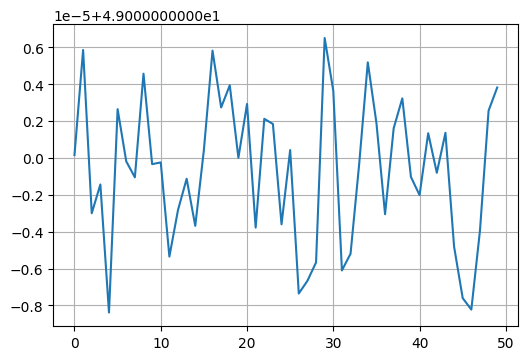

In [51]:
plt.plot(range(len(rlistA)), rlistA)
plt.show()

In [52]:
trainB.shape[1]

420

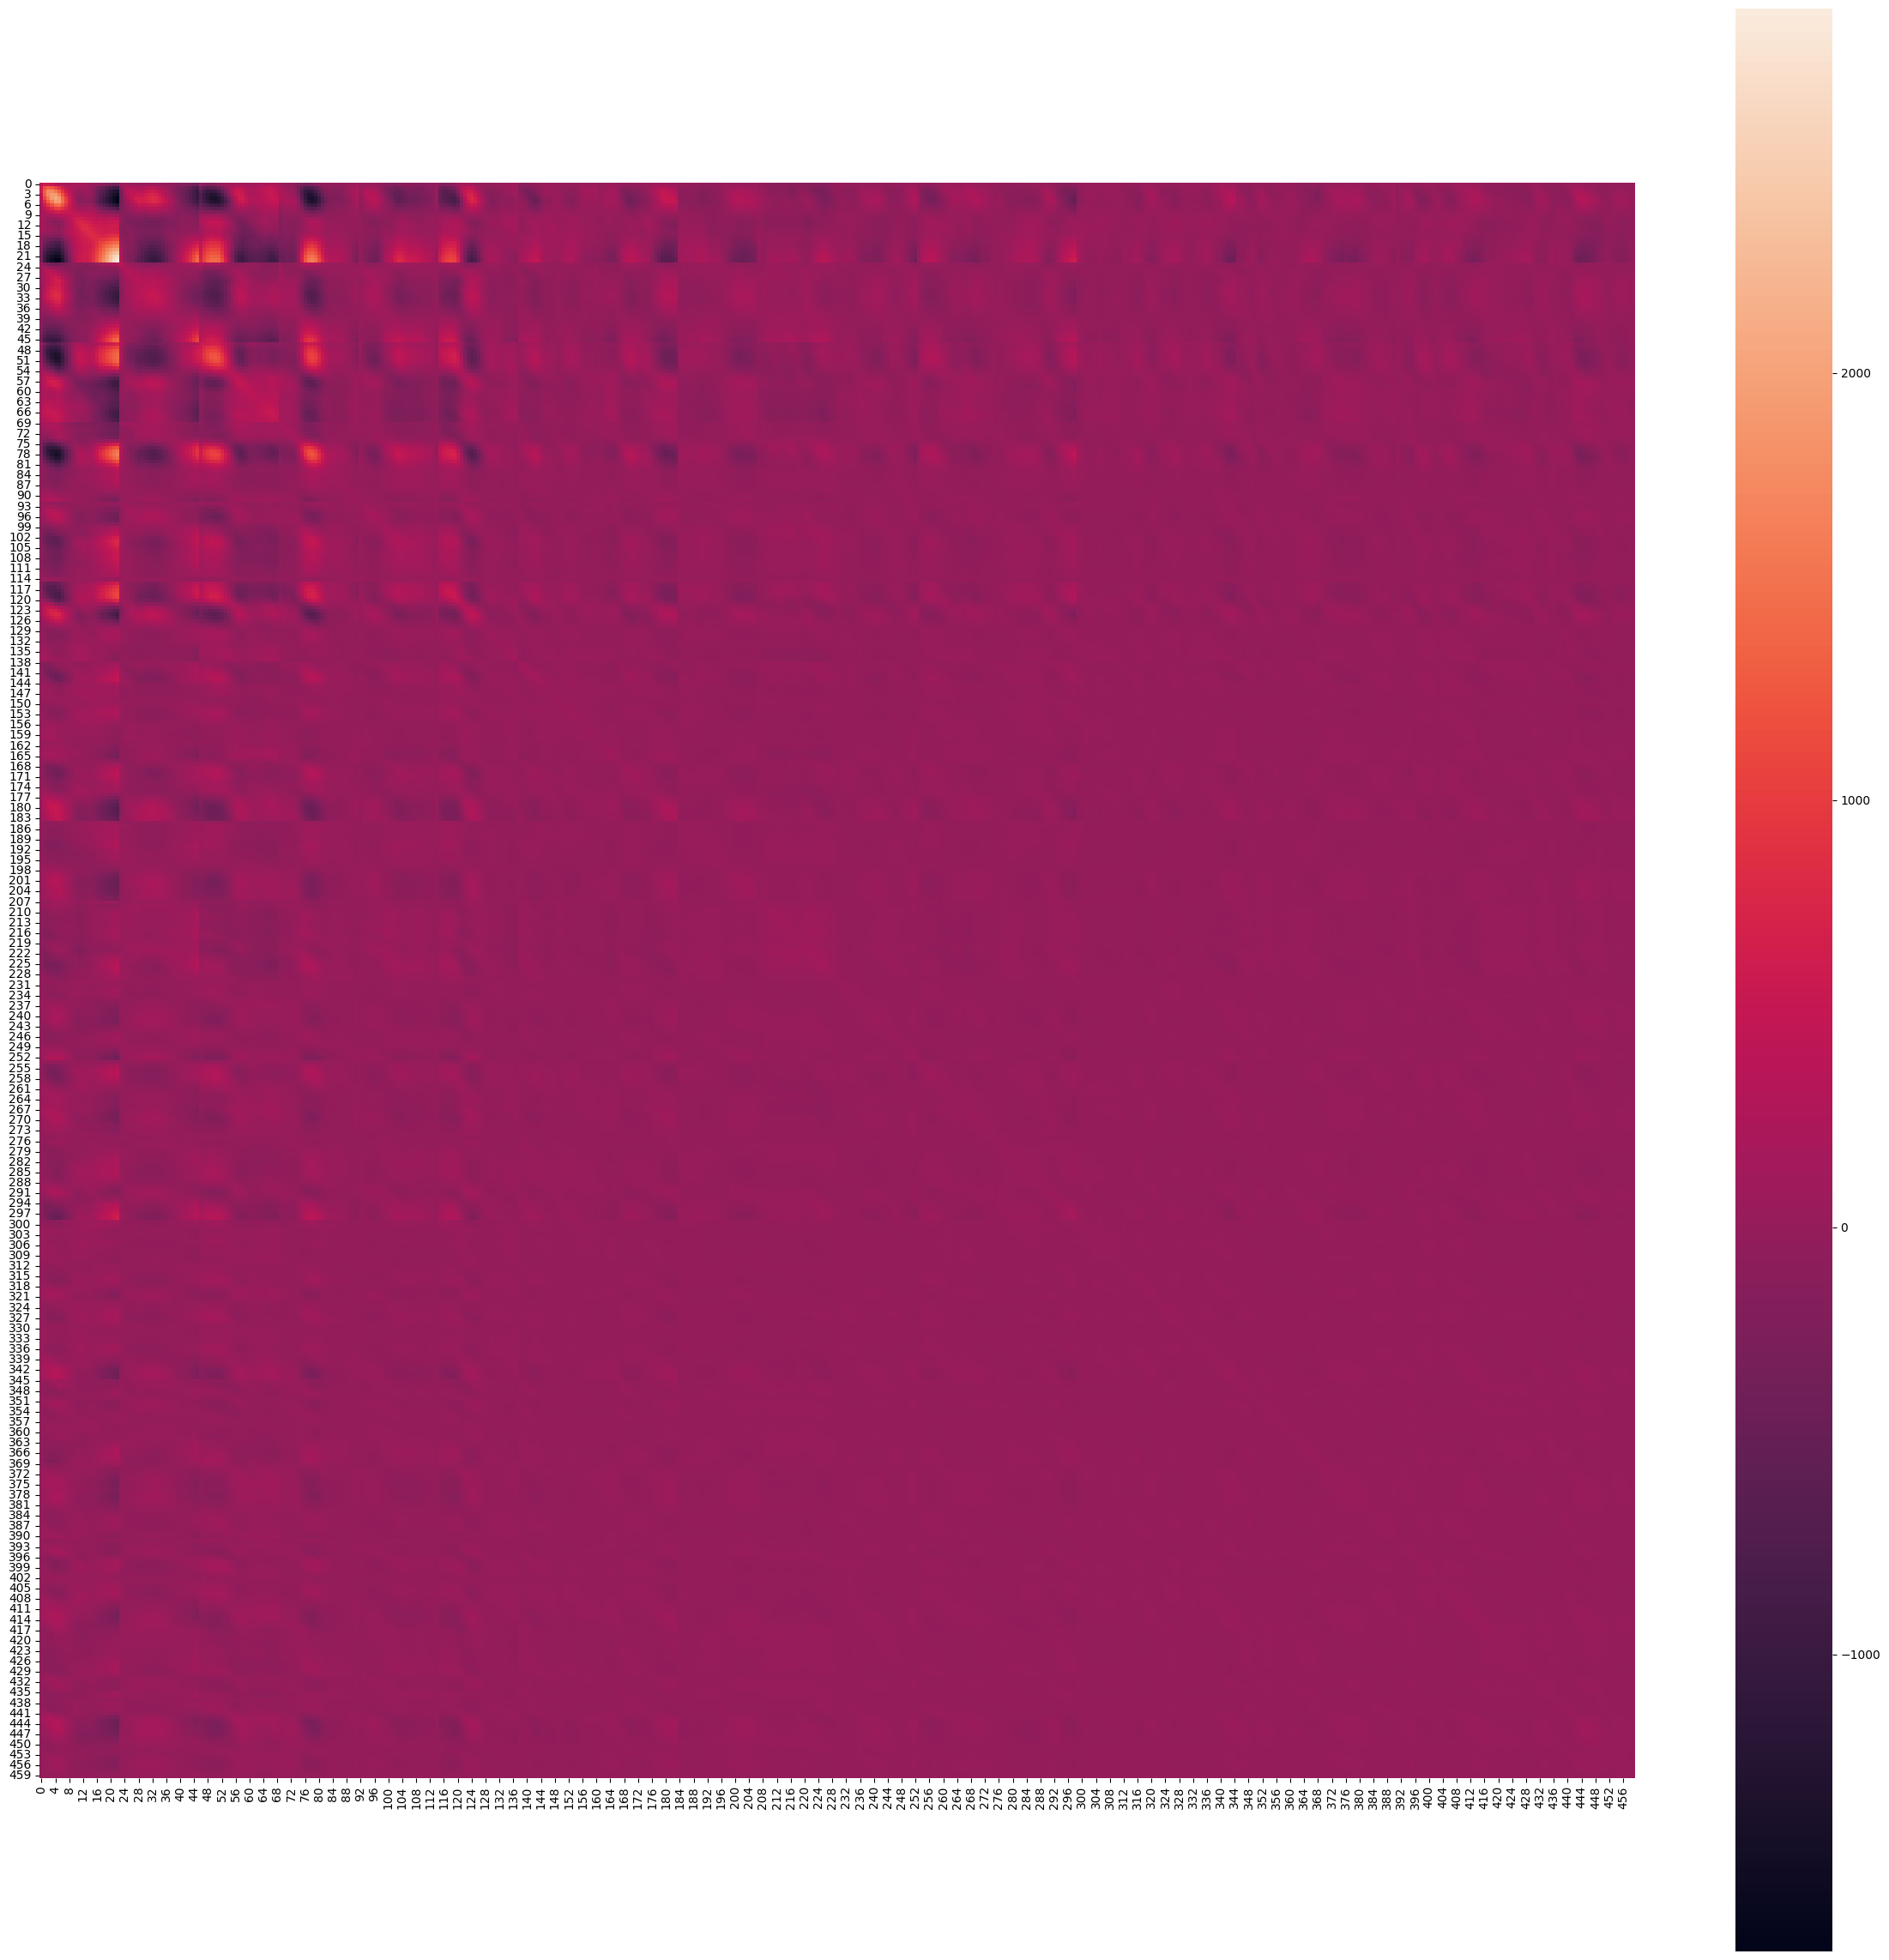

In [53]:
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot()
sns.heatmap(np.squeeze(gmA.covariances_, axis=0), square=True, ax=ax)
plt.show()

In [ ]:
fsdd = FSDD('../Datasets/FSDD/recordings')
filesA, filesB = fsdd.getFilesForDigit(0, spkA=0, spkB=3)

train2, nx, ny = getTrainSet([*filesA, *filesB])

gm2 = GaussianMixture(n_components=2, random_state=0).fit(train2)

for i in range(len(filesA)):
	for j in range(len(filesB)):
		test2 = [train2[i], train2[-j-1]]
		a, b = gm2.predict(test2)
		if a == b:
			print(i, j)

nx = 20, ny = 15


In [ ]:
gm2.covariances_.shape

(2, 300, 300)

In [ ]:
# fig = plt.figure(figsize=(30, 30))
# ax = fig.add_subplot()
# sns.heatmap(gm2.covariances_[0], square=True, ax=ax)
# plt.show()

In [54]:
fsdd = FSDD('../Datasets/FSDD/recordings')
print(fsdd.speakers)
# spkA = 1
# spkB = 3
filesA, filesB = fsdd.getFilesForDigit(0, spkA=spkA, spkB=spkB)
print(fsdd.speakers[spkA])
print(fsdd.speakers[spkB])

mfccsA = getFeatureList(filesA)
mfccsB = getFeatureList(filesB)
mfccsA, mfccsB = trimFeatures([mfccsA, mfccsB])
# shapesA = {a.shape for a in mfccsA}
# shapesB = {b.shape for b in mfccsB}
# print(shapesA)
# print(shapesB)

deltasA = getDeltasList(filesA)
deltasB = getDeltasList(filesB)
deltasA, deltasB = trimFeatures([deltasA, deltasB])

['nicolas', 'george', 'yweweler', 'jackson', 'theo', 'lucas']
jackson
lucas


In [55]:
print(mfccsA[0].shape)
print(mfccsB[0].shape)
print(deltasA[0].shape)
print(deltasB[0].shape)

(12, 41)
(12, 41)
(12, 41)
(12, 41)


In [56]:
# train test split
testsize = 25

train3, nx, ny = getLinearFeatureList([*mfccsA[:-testsize], *mfccsB[:-testsize]])
test3, nx, ny = getLinearFeatureList([*mfccsA[-testsize:], *mfccsB[-testsize:]])

gm3 = GaussianMixture(n_components=2, random_state=0).fit(train3)

Y = gm3.predict(test3)
print(Y)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 0 0]


In [57]:
# train test split
testsize = 47

train4A, nx, ny = getLinearFeatureList(mfccsA[:-testsize])
train4B, nx, ny = getLinearFeatureList(mfccsB[:-testsize])

test4A, nx, ny = getLinearFeatureList(mfccsA[-testsize:])
test4B, nx, ny = getLinearFeatureList(mfccsB[-testsize:])
print(nx, ny)

gm4A = GaussianMixture(n_components=1, max_iter=200, n_init=3).fit(train4A)
gm4B = GaussianMixture(n_components=1, max_iter=200, n_init=3).fit(train4B)


12 41


In [58]:
# train test split
testsize = 47

train4A = np.hstack(mfccsA[:-testsize]).T
train4B = np.hstack(mfccsB[:-testsize]).T

test4A = np.hstack(mfccsA[-testsize:]).T
test4B = np.hstack(mfccsB[-testsize:]).T

print(train4A.shape)
print(train4B.shape)
print(test4A.shape)
print(test4B.shape)

gm4A = GaussianMixture(n_components=16, max_iter=200, n_init=3).fit(train4A)
gm4B = GaussianMixture(n_components=16, max_iter=200, n_init=3).fit(train4B)

(123, 12)
(123, 12)
(1927, 12)
(1927, 12)


In [59]:
rlistA = []
for el in train4A:
    r = gm4A.score(el.reshape(1, -1))
    rlistA.append(r)
print(max(rlistA))

rlistA = []
for el in test4A:
    r = gm4A.score(el.reshape(1, -1))
    rlistA.append(r)
print(max(rlistA))

rlistA = []
for el in train4B:
    r = gm4A.score(el.reshape(1, -1))
    rlistA.append(r)
print(max(rlistA))

rlistA = []
for el in test4B:
    r = gm4A.score(el.reshape(1, -1))
    rlistA.append(r)
print(max(rlistA))

46.846249895112884
-471.5780474631991
-3899.7596871245196
-1131.0573152338245


In [71]:
featuresListA = []
for spkFeatures in zip(mfccsA, deltasA):
    f = np.vstack(spkFeatures)
    featuresListA.append(f)


featuresListB = []
for spkFeatures in zip(mfccsB, deltasB):
    f = np.vstack(spkFeatures)
    featuresListB.append(f)

# train test split
testsize = 5

train4A = np.hstack(featuresListA[:-testsize]).T
train4B = np.hstack(featuresListB[:-testsize]).T

test4A = np.hstack(featuresListA[-testsize:]).T
test4B = np.hstack(featuresListB[-testsize:]).T

print(train4A.shape)
print(train4B.shape)
print(test4A.shape)
print(test4B.shape)

gm4A = GaussianMixture(n_components=1, max_iter=200, n_init=3).fit(train4A)
gm4B = GaussianMixture(n_components=1, max_iter=200, n_init=3).fit(train4B)

print('Means')
print(gm4A.means_.shape)
print(gm4B.means_.shape)

print('Covariances')
print(gm4A.covariances_.shape)
print(gm4B.covariances_.shape)

# rlistA = []
# for el in train4A:
#     r = gm4A.score(el.reshape(1, -1))
#     rlistA.append(r)
# print(max(rlistA))

# rlistA = []
# for el in test4A:
#     r = gm4A.score(el.reshape(1, -1))
#     rlistA.append(r)
# print(max(rlistA))

# rlistA = []
# for el in train4B:
#     r = gm4A.score(el.reshape(1, -1))
#     rlistA.append(r)
# print(max(rlistA))

# rlistA = []
# for el in test4B:
#     r = gm4A.score(el.reshape(1, -1))
#     rlistA.append(r)
# print(max(rlistA))

(1845, 24)
(1845, 24)
(205, 24)
(205, 24)
Means
(1, 24)
(1, 24)
Covariances
(1, 24, 24)
(1, 24, 24)


In [72]:
nTimestamps = 1000
print(gm4A.score(test4A[:nTimestamps]))
print(gm4A.score(test4B[:nTimestamps]))
print('======================')
print(gm4B.score(test4A[:nTimestamps]))
print(gm4B.score(test4B[:nTimestamps]))

-45.473866142999704
-79.41012932170014
-90.44100169658921
-51.60453888618183


F-stat: 1.5230390022033227
Mean: 7.849839743901486
Max: 35.16490116424465


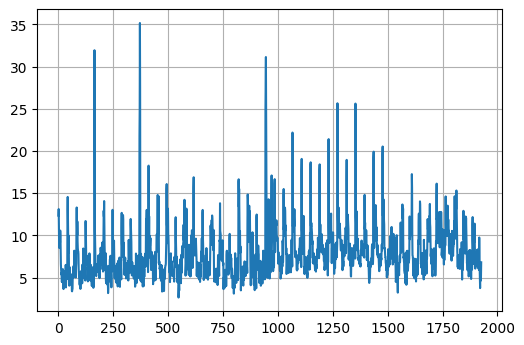

In [62]:
n = len(test4A)
k = len(test4A[0])
Fstat = scipy.stats.f.ppf(q=1-0.05, dfn=k, dfd=n-k)
print(f'F-stat: {Fstat}')

rlistA = []
for el in test4A:
    x = el
    means = np.squeeze(gm4A.means_)
    cov = np.squeeze(gm4A.covariances_)

    # r = ((n - k) / (k * (n - 1))) * n * (x - means).T @ np.linalg.inv(cov) @ (x - means)
    r = np.sqrt((x - means).T @ np.linalg.inv(cov) @ (x - means))
    rlistA.append(r)
# print(rlistA)
print(f'Mean: {np.mean(rlistA)}')
print(f'Max: {np.max(rlistA)}')

plt.plot(range(len(rlistA)), rlistA)
plt.show()

Mean: 16.247580234037606
Min: 5.913998556547178


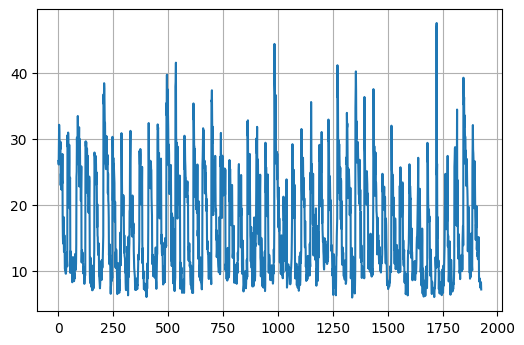

In [63]:
rlistA = []
for el in test4B:
    x = el
    means = np.squeeze(gm4A.means_)
    cov = np.squeeze(gm4A.covariances_)

    # r = ((n - k) / (k * (n - 1))) * n * (x - means).T @ np.linalg.inv(cov) @ (x - means)
    r = np.sqrt((x - means).T @ np.linalg.inv(cov) @ (x - means))
    rlistA.append(r)
# print(rlistA)
print(f'Mean: {np.mean(rlistA)}')
print(f'Min: {np.min(rlistA)}')
plt.plot(range(len(rlistA)), rlistA)
plt.show()

In [64]:
print(gm4A.means_.shape)
print(gm4A.covariances_.shape)

(1, 24)
(1, 24, 24)


## F stat

Mean: 296.7690246647994
Max: 5142.66264520897


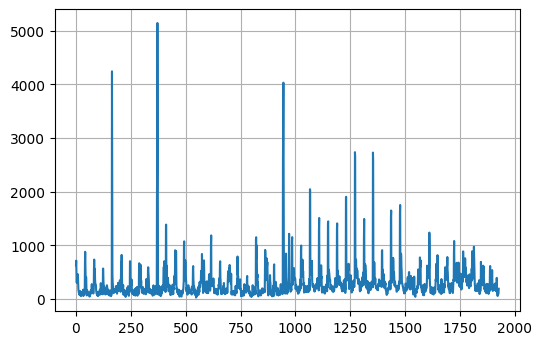

In [65]:
a = len(train4A)
N = len(train4A[0])

rlistA = []
for el in test4A:
    x = el
    means = np.squeeze(gm4A.means_)
    cov = np.squeeze(gm4A.covariances_)

    r = ((a-N) / (N * (a-1))) * a * (x - means).T @ np.linalg.inv(cov) @ (x - means) 
    rlistA.append(r)
print(f'Mean: {np.mean(rlistA)}')
print(f'Max: {np.max(rlistA)}')
plt.plot(range(len(rlistA)), rlistA)
plt.show()

Mean: 1350.9975393449643
Min: 145.45600723775846


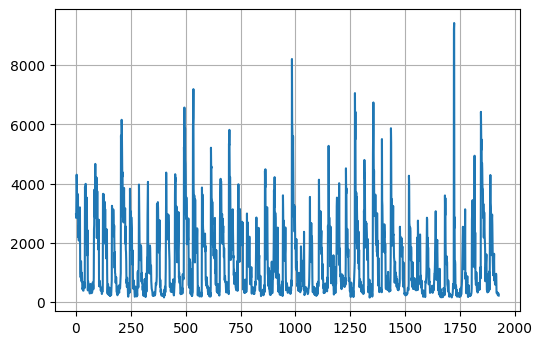

In [66]:
a = len(train4A)
N = len(train4A[0])

rlistB = []
for el in test4B:
    x = el
    means = np.squeeze(gm4A.means_)
    cov = np.squeeze(gm4A.covariances_)

    r = ((a-N) / (N * (a-1))) * a * (x - means).T @ np.linalg.inv(cov) @ (x - means) 
    rlistB.append(r)
print(f'Mean: {np.mean(rlistB)}')
print(f'Min: {np.min(rlistB)}')
plt.plot(range(len(rlistB)), rlistB)
plt.show()

In [67]:
n = len(train4A)
k = len(train4A[0])
scipy.stats.f.ppf(q=1-0.05, dfn=k-1, dfd=n-k)

1.6389026897437053

In [73]:
print('Mahalanobis train')
rlistA = []
for el in train4A:
    x = el
    means = np.squeeze(gm4A.means_)
    cov = np.squeeze(gm4A.covariances_)

    r = np.sqrt((x - means).T @ np.linalg.inv(cov) @ (x - means)) # mahalanobis(x, means, np.linalg.inv(cov))
    rlistA.append(r)
# print(rlistA)
print(np.mean(rlistA))

rlistA = []
for el in train4B:
    x = el
    means = np.squeeze(gm4A.means_)
    cov = np.squeeze(gm4A.covariances_)

    r = np.sqrt((x - means).T @ np.linalg.inv(cov) @ (x - means)) # mahalanobis(x, means, np.linalg.inv(cov))
    rlistA.append(r)
# print(rlistA)
print(np.mean(rlistA))

rlistB = []
for el in train4A:
    x = el
    means = np.squeeze(gm4B.means_)
    cov = np.squeeze(gm4B.covariances_)

    r = np.sqrt((x - means).T @ np.linalg.inv(cov) @ (x - means)) # mahalanobis(x, means, np.linalg.inv(cov))
    rlistB.append(r)
# print(rlistB)
print(np.mean(rlistB))


rlistB = []
for el in train4B:
    x = el
    means = np.squeeze(gm4B.means_)
    cov = np.squeeze(gm4B.covariances_)

    r = np.sqrt((x - means).T @ np.linalg.inv(cov) @ (x - means)) # mahalanobis(x, means, np.linalg.inv(cov))
    rlistB.append(r)
# print(rlistB)
print(np.mean(rlistB))

print('Mahalanobis test')
rlistA = []
for el in test4A:
    x = el
    means = np.squeeze(gm4A.means_)
    cov = np.squeeze(gm4A.covariances_)

    r = np.sqrt((x - means).T @ np.linalg.inv(cov) @ (x - means)) # mahalanobis(x, means, np.linalg.inv(cov))
    rlistA.append(r)
# print(rlistA)
print(np.mean(rlistA))


rlistA = []
for el in test4B:
    x = el
    means = np.squeeze(gm4A.means_)
    cov = np.squeeze(gm4A.covariances_)

    r = np.sqrt((x - means).T @ np.linalg.inv(cov) @ (x - means)) # mahalanobis(x, means, np.linalg.inv(cov))
    rlistA.append(r)
# print(rlistA)
print(np.mean(rlistA))

rlistB = []
for el in test4A:
    x = el
    means = np.squeeze(gm4B.means_)
    cov = np.squeeze(gm4B.covariances_)

    r = np.sqrt((x - means).T @ np.linalg.inv(cov) @ (x - means)) # mahalanobis(x, means, np.linalg.inv(cov))
    rlistB.append(r)
# print(rlistB)
print(np.mean(rlistB))


rlistB = []
for el in test4B:
    x = el
    means = np.squeeze(gm4B.means_)
    cov = np.squeeze(gm4B.covariances_)

    r = np.sqrt((x - means).T @ np.linalg.inv(cov) @ (x - means)) # mahalanobis(x, means, np.linalg.inv(cov))
    rlistB.append(r)
# print(rlistB)
print(np.mean(rlistB))

Mahalanobis train
4.700865901892879
9.350393136914667
9.39753034316556
4.677096443260082
Mahalanobis test
5.071654684192044
9.160822685484884
10.574604656558602
5.477667250224864


In [ ]:
#Calculate and returns the delta of given feature vector matrix
def calculate_delta(array):
    rows,cols = array.shape
    deltas = np.zeros((rows,cols))
    N = 2
    for i in range(rows):
        index = []
        j = 1
        while j <= N:
            if i-j < 0:
                first = 0
            else:
                first = i-j
            if i+j > rows -1:
                second = rows -1
            else:
                second = i+j
            index.append((second,first))
            j+=1
        deltas[i] = ( array[index[0][0]]-array[index[0][1]] + (2 * (array[index[1][0]]-array[index[1][1]])) ) / 10
    return deltas

#convert audio to mfcc features
def extract_features(audio,rate):    
    mfcc_feat = mfcc.mfcc(audio,rate, 0.025, 0.01,20,appendEnergy = True, nfft=1103)
    mfcc_feat = preprocessing.scale(mfcc_feat)
    delta = calculate_delta(mfcc_feat)

    #combining both mfcc features and delta
    combined = np.hstack((mfcc_feat,delta)) 
    return combined

audio, rate = librosa.load(filesA[6])
mfcc_feat = mfcc.mfcc(audio,rate, 0.025, 0.01,20,appendEnergy = True, nfft=1103)
mfcc_feat = preprocessing.scale(mfcc_feat)
delta = calculate_delta(mfcc_feat)

In [ ]:
# im = cv2.imread("file.png", cv2.IMREAD_GRAYSCALE)
# librdel = librosa.feature.delta(im, width=3, axis=0)
# plt.imshow(librdel, cmap='gray')
# plt.show()

# deltaIm = calculate_delta(im)
# plt.imshow(deltaIm, cmap='gray')
# plt.show()

In [ ]:
# plt.matshow(mfcc_feat)
# plt.show()

In [ ]:
# plt.matshow(delta)
# plt.show()

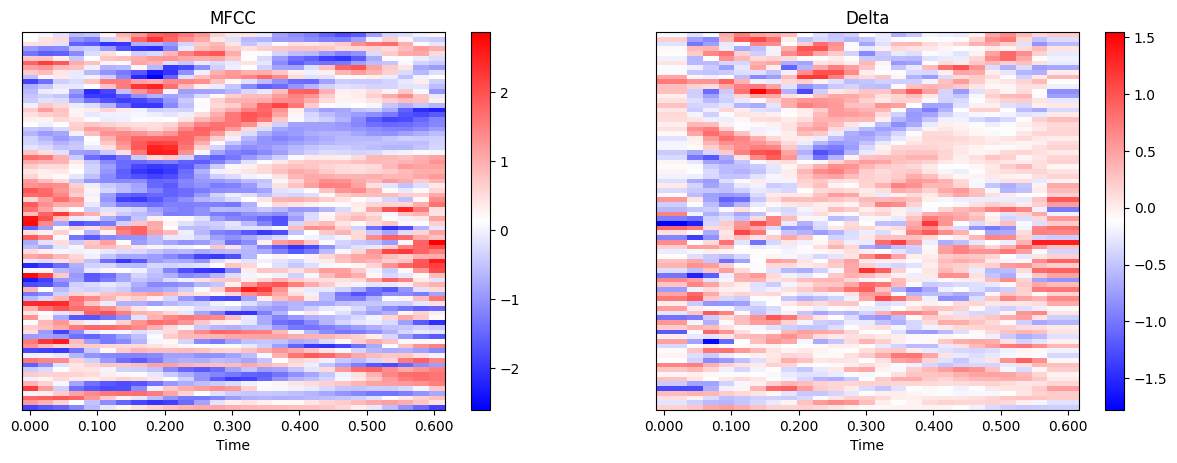

In [41]:
filesample = 25
audio, rate = librosa.load(filesA[filesample])


mfccA, srA, = getMFCC(filesA[filesample], useStd=True)
deltaA = librosa.feature.delta(mfccA, width=3)

compareFeatures(mfccA, srA, deltaA, srA, 'MFCC', 'Delta')
plt.show()

In [31]:
print(len(train4A))
print(len(train4A[0]))

123
24


In [32]:
a = len(train4A)
N = len(train4A[0])
scipy.stats.f.ppf(q=1-0.05, dfn=a-1, dfd=N-a)

nan

In [34]:
rlistA = []
for el in test4A:
    x = el
    means = np.squeeze(gm4A.means_)
    cov = np.squeeze(gm4A.covariances_)

    r = ((a-N) / (N * (a-1))) * a * (x - means).T @ np.linalg.inv(cov) @ (x - means) 
    rlistA.append(r)
# print(rlistA)
print(max(rlistA))

5142.66264520897


In [36]:
rlistB = []
for el in test4B:
    x = el
    means = np.squeeze(gm4A.means_)
    cov = np.squeeze(gm4A.covariances_)

    r = np.sqrt((x - means).T @ np.linalg.inv(cov) @ (x - means))
    rlistB.append(r)
# print(rlistB)
print(min(rlistB))

5.913998556547178


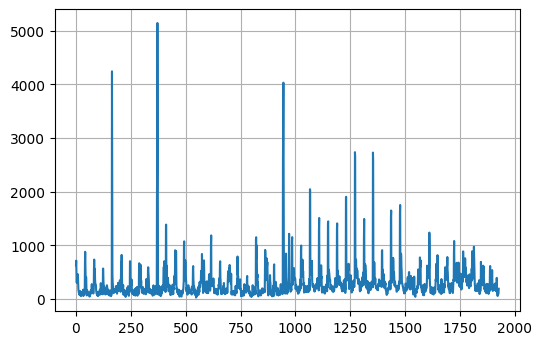

In [37]:
plt.plot(range(len(rlistA)), rlistA)
plt.show()

In [38]:
sample4a = gm4A.sample(1)[0].reshape((nx, ny))
sample4b = gm4B.sample(1)[0].reshape((nx, ny))

ValueError: cannot reshape array of size 24 into shape (12,41)

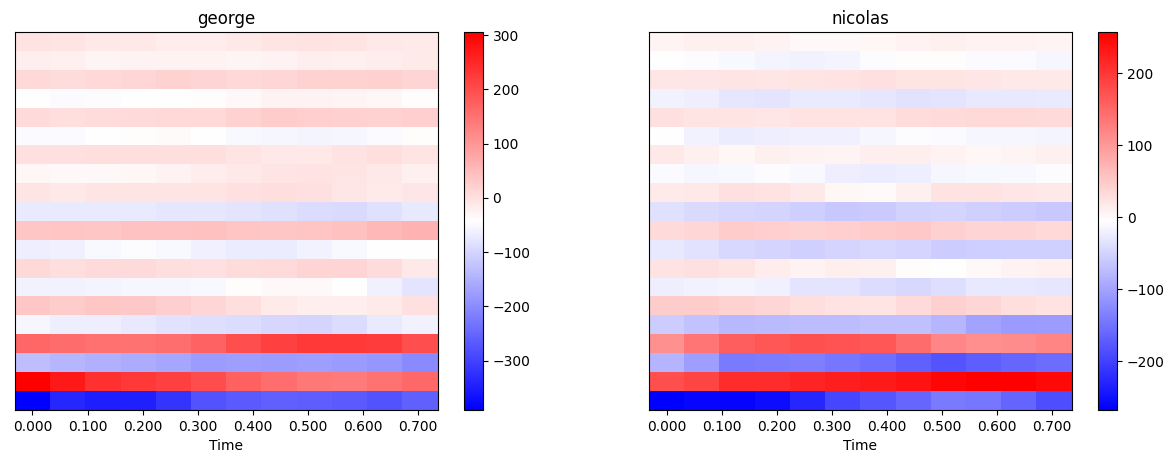

In [ ]:
fig, ax = compareFeatures(sample4a, 8000, sample4b, 8000, fsdd.speakers[spkA], fsdd.speakers[spkB])
plt.show()

In [39]:
maxDistSameA = max([np.mean((gm4A.means_ - ta)**2) for ta in test4A])
maxDistSameB = max([np.mean((gm4B.means_ - tb)**2) for tb in test4B])
print(f'Maximum distanse to center of valid:')
print(maxDistSameA)
print(maxDistSameB)
minDistDifA = min([np.mean((gm4A.means_ - tb)**2) for tb in test4B])
minDistDifB = min([np.mean((gm4B.means_ - ta)**2) for ta in test4A])
print(f'Minimum distanse to center of another:')
print(minDistDifA)
print(minDistDifB)

Maximum distanse to center of valid:
3804.6856654444514
3910.189863352453
Minimum distanse to center of another:
100.82963444284854
281.70506923374995


In [ ]:
cosDist = sklearn.metrics.pairwise.cosine_distances
maxDistSameA = max([cosDist(gm4A.means_.reshape(1, -1), ta.reshape(1, -1)) for ta in test4A])
maxDistSameB = max([cosDist(gm4B.means_.reshape(1, -1), tb.reshape(1, -1)) for tb in test4B])
print(f'Maximum cos dist to center of valid:')
print(maxDistSameA)
print(maxDistSameB)
minDistDifA = min([cosDist(gm4A.means_.reshape(1, -1), tb.reshape(1, -1)) for tb in test4B])
minDistDifB = min([cosDist(gm4B.means_.reshape(1, -1), ta.reshape(1, -1)) for ta in test4A])
print(f'Minimum cos dist to center of another:')
print(minDistDifA)
print(minDistDifB)

Maximum cos dist to center of valid:
[[0.00662717]]
[[0.0042129]]
Minimum cos dist to center of another:
[[0.02492578]]
[[0.03327519]]


In [ ]:
# dist = sklearn.metrics.pairwise.manhattan_distances
dist = sklearn.metrics.pairwise.euclidean_distances
maxDistSameA = max([dist(gm4A.means_.reshape(1, -1), ta.reshape(1, -1)) for ta in test4A])
maxDistSameB = max([dist(gm4B.means_.reshape(1, -1), tb.reshape(1, -1)) for tb in test4B])
print(f'Maximum dist to center of valid:')
print(maxDistSameA)
print(maxDistSameB)
minDistDifA = min([dist(gm4A.means_.reshape(1, -1), tb.reshape(1, -1)) for tb in test4B])
minDistDifB = min([dist(gm4B.means_.reshape(1, -1), ta.reshape(1, -1)) for ta in test4A])
print(f'Minimum dist to center of another:')
print(minDistDifA)
print(minDistDifB)

Maximum dist to center of valid:
[[163.59614099]]
[[149.25448565]]
Minimum dist to center of another:
[[340.18002298]]
[[372.10343761]]


In [ ]:
cosDist = sklearn.metrics.pairwise.cosine_distances
maxDistSameA = [cosDist(gm4A.means_.reshape(1, -1), ta.reshape(1, -1)).reshape(1)[0] for ta in test4A]
maxDistSameB = [cosDist(gm4B.means_.reshape(1, -1), tb.reshape(1, -1)).reshape(1)[0] for tb in test4B]
print(f'Maximum cos dist to center of valid:')
print(maxDistSameA)
print(maxDistSameB)
minDistDifA = [cosDist(gm4A.means_.reshape(1, -1), tb.reshape(1, -1)).reshape(1)[0] for tb in test4B]
minDistDifB = [cosDist(gm4B.means_.reshape(1, -1), ta.reshape(1, -1)).reshape(1)[0] for ta in test4A]
print(f'Minimum cos dist to center of another:')
print(minDistDifA)
print(minDistDifB)

Maximum cos dist to center of valid:
[0.0016448838384519604, 0.0010362174344308306, 0.0016009652352636516, 0.0023122358419336297, 0.004212900729343327]
[0.004255939838346934, 0.00662717304942928, 0.0037407003183806964, 0.0063756092709850165, 0.005315440915569236]
Minimum cos dist to center of another:
[0.03533937016052424, 0.03619387783986794, 0.033275186655305045, 0.03923102083968444, 0.03460776254390974]
[0.028893752586499732, 0.027420037550162313, 0.027270047049023916, 0.02691663764806551, 0.024925782437525412]


In [ ]:
gm4A.lower_bound_

1007.9309487252091

In [ ]:
gm4A.score_samples(test4A)

array([-9.77489597e+08, -6.22413467e+08, -9.77647703e+08, -1.36463387e+09,
       -1.06029442e+09])

In [ ]:
gm4A.score_samples(test4B)

array([-3.34768731e+10, -3.56301715e+10, -3.34658385e+10, -3.43297538e+10,
       -3.34956103e+10])